In [1]:
%matplotlib inline
import scipy.misc
import numpy as np
import pandas as pd

import random
import math
import itertools

from cvxpy import *
from PIL import Image
import matplotlib.pyplot as plt

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,0.0,213.0,233.0,125.0,0.0,139.0,0.0,210.0,0.0,0.0,...,0.0,0.0,78.0,66.0,85.0,127.0,105.0,0.0,0.0,0.0
1,169.0,207.0,254.0,184.0,0.0,0.0,141.0,156.0,0.0,0.0,...,92.0,67.0,0.0,0.0,78.0,120.0,0.0,0.0,132.0,117.0
2,0.0,0.0,151.0,0.0,154.0,0.0,0.0,138.0,154.0,201.0,...,57.0,70.0,0.0,48.0,86.0,116.0,102.0,0.0,0.0,101.0
3,155.0,0.0,152.0,184.0,189.0,0.0,83.0,0.0,136.0,0.0,...,41.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,115.0,79.0
4,148.0,0.0,0.0,165.0,0.0,189.0,0.0,179.0,0.0,0.0,...,0.0,99.0,86.0,42.0,0.0,0.0,0.0,0.0,87.0,0.0


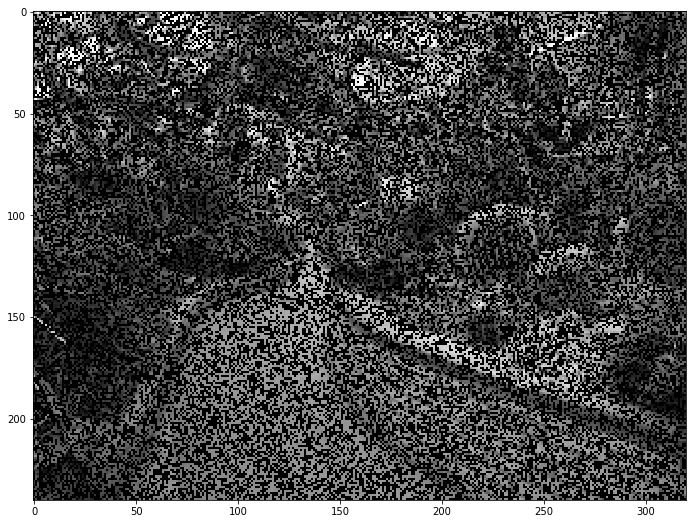

In [2]:
#importing original picture
img_orig = Image.open('original.JPG')
imggray_orig = img_orig.convert('LA')

imgmat_orig = np.array(list(imggray_orig.getdata(band=0)), float)
imgmat_orig.shape = (imggray_orig.size[1], imggray_orig.size[0])
imgmat_orig = np.matrix(imgmat_orig)
reconstimg_orig = imgmat_orig
array2matrix_orig = pd.DataFrame(reconstimg_orig)


#importing corrupted picture
img = Image.open('corrupted_image (1).png')
imggray = img.convert('LA')

imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(12,9))
plt.imshow(imgmat, cmap='gray');
reconstimg = imgmat
array2matrix = pd.DataFrame(reconstimg)
array2matrix.head()

In [3]:
'''
   Copyright 2015 Travis Brady
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''
from __future__ import print_function
import numpy as np


def frob(Uold, Dsqold, Vold, U, Dsq, V):
    denom = (Dsqold ** 2).sum()
    utu = Dsq * (U.T.dot(Uold))
    vtv = Dsqold * (Vold.T.dot(V))
    uvprod = utu.dot(vtv).diagonal().sum()
    num = denom + (Dsqold ** 2).sum() - 2*uvprod
    return num / max(denom, 1e-9)

class SoftImpute:
    def __init__(self, J=2, thresh=1e-05, lambda_=0, maxit=100, random_state=None, verbose=False):
        self.J = J
        self.thresh = thresh
        self.lambda_ = lambda_
        self.maxit = maxit
        self.rs = np.random.RandomState(random_state)
        self.verbose = verbose
        self.u = None
        self.d = None
        self.v = None

    def fit(self, X):
        n,m = X.shape
        xnas = np.isnan(X)
        nz = m*n - xnas.sum()
        xfill = X.copy()
        V = np.zeros((m, self.J))
        U = self.rs.normal(0.0, 1.0, (n, self.J))
        U, _, _ = np.linalg.svd(U, full_matrices=False)
        Dsq = np.ones((self.J, 1))
        #xfill[xnas] = 0.0
        col_means = np.nanmean(xfill, axis=0)
        np.copyto(xfill, col_means, where=np.isnan(xfill))
        ratio = 1.0
        iters = 0
        while ratio > self.thresh and iters < self.maxit:
            iters += 1
            U_old = U
            V_old = V
            Dsq_old = Dsq
            B = U.T.dot(xfill)

            if self.lambda_ > 0:
                tmp = (Dsq / (Dsq + self.lambda_))
                B = B * tmp

            Bsvd = np.linalg.svd(B.T, full_matrices=False)
            V = Bsvd[0]
            Dsq = Bsvd[1][:, np.newaxis]
            U = U.dot(Bsvd[2])

            tmp = Dsq * V.T

            xhat = U.dot(tmp)

            xfill[xnas] = xhat[xnas]
            A = xfill.dot(V).T
            Asvd = np.linalg.svd(A.T, full_matrices=False)
            U = Asvd[0]
            Dsq = Asvd[1][:, np.newaxis]
            V = V.dot(Asvd[2])
            tmp = Dsq * V.T

            xhat = U.dot(tmp)
            xfill[xnas] = xhat[xnas]
            ratio = frob(U_old, Dsq_old, V_old, U, Dsq, V)
            if self.verbose:
                print('iter: %4d ratio = %.5f' % (iters, ratio))

        self.u = U[:,:self.J]
        self.d = Dsq[:self.J]
        self.v = V[:,:self.J]
        return self

    def suv(self, vd):
        res = self.u.dot(vd.T)
        return res

    def predict(self, X, copyto=False):
        vd = self.v * np.outer(np.ones(self.v.shape[0]), self.d)
        X_imp = self.suv(vd)
        if copyto:
            np.copyto(X, X_imp, where=np.isnan(X))
        else:
            return X_imp

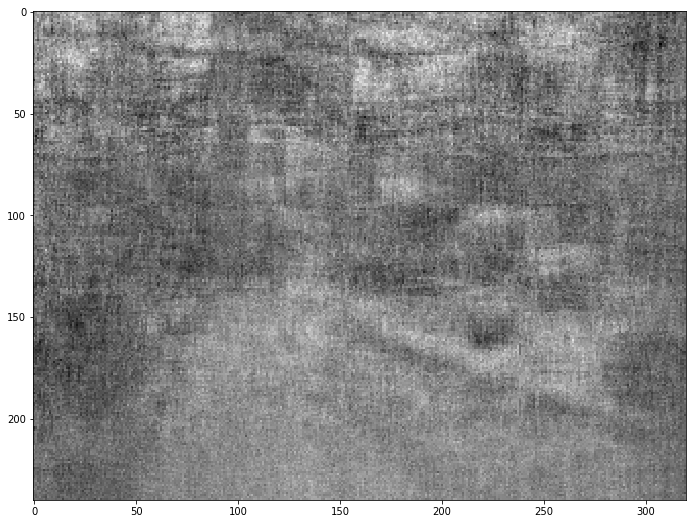

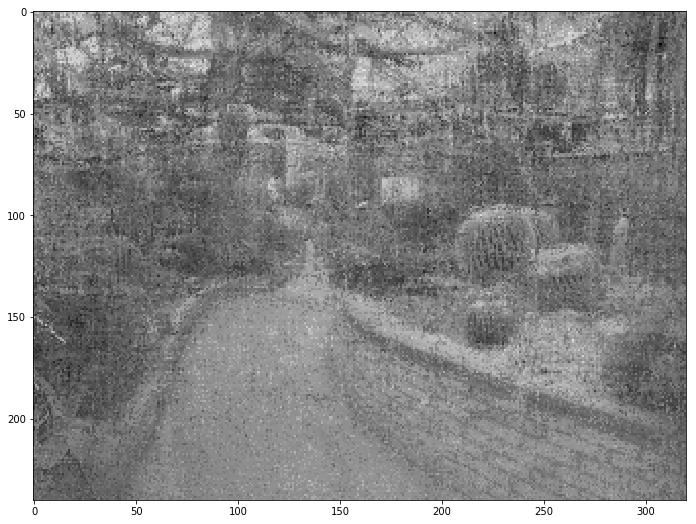

In [4]:
array2matrix.replace(0, np.nan,inplace=True)
rank = 232
lambda_ = 0

clf = SoftImpute(J=rank, lambda_=lambda_)
fit = clf.fit(array2matrix.values)
X_imp = clf.predict(array2matrix.values)
plt.figure(figsize=(12, 9))
plt.imshow(X_imp, cmap='gray');


### add a mask ###
array2matrix_ = array2matrix.copy()
Nas = np.where(np.asanyarray(np.isnan(array2matrix_))) #finding NAs coordinates
nonNas = np.where(np.asanyarray(1-np.isnan(array2matrix_))) #finding nonNAs coordinates
omega= [list(t) for t in zip(nonNas[0], nonNas[1])] #list of nonNas coordinates
def _get_mask_matrix(n_1, n_2, omega):
    """
    If we observed entry (i, j) of matrix M, the entry of mask matrix is 1,
    Otherwise 0.
    """
    mask = np.zeros((n_1, n_2), dtype=np.int8)
    for i, j in omega:
        mask[i, j] = 1
    return mask

def _get_anti_mask_matrix(n_1, n_2, omega):
    """
    If we observed entry (i, j) of matrix M, the entry of mask matrix is 1,
    Otherwise 0.
    """
    anti_mask = np.zeros((n_1, n_2), dtype=np.int8)+1
    for i, j in omega:
        anti_mask[i, j] = 0
    return anti_mask

n_1 = array2matrix_.shape[0]
n_2 = array2matrix_.shape[1]
mask = _get_mask_matrix(n_1, n_2, omega)
anti_mask = _get_anti_mask_matrix(n_1, n_2, omega)


array2matrix.replace(np.nan, 0,inplace=True) #replace NA with zero

mask_image = array2matrix + np.multiply(anti_mask,X_imp)
plt.figure(figsize=(12, 9))
plt.imshow(mask_image, cmap='gray');

# RMSE

In [5]:
numerator = (pd.DataFrame((np.multiply(anti_mask,reconstimg_orig) - np.multiply(anti_mask,X_imp)))**2).values.sum()
denominator = anti_mask.sum()
RMSE = (numerator/denominator)**(0.5)

RMSE

42.548541800749227

# For loops to find the best arguments

In [6]:
array2matrix.replace(0, np.nan,inplace=True)

### add a mask ###
array2matrix_ = array2matrix.copy()
Nas = np.where(np.asanyarray(np.isnan(array2matrix_))) #finding NAs coordinates
nonNas = np.where(np.asanyarray(1-np.isnan(array2matrix_))) #finding nonNAs coordinates
omega= [list(t) for t in zip(nonNas[0], nonNas[1])] #list of nonNas coordinates
def _get_mask_matrix(n_1, n_2, omega):
    """
    If we observed entry (i, j) of matrix M, the entry of mask matrix is 1,
    Otherwise 0.
    """
    mask = np.zeros((n_1, n_2), dtype=np.int8)
    for i, j in omega:
        mask[i, j] = 1
    return mask

def _get_anti_mask_matrix(n_1, n_2, omega):
    """
    If we observed entry (i, j) of matrix M, the entry of mask matrix is 1,
    Otherwise 0.
    """
    anti_mask = np.zeros((n_1, n_2), dtype=np.int8)+1
    for i, j in omega:
        anti_mask[i, j] = 0
    return anti_mask

n_1 = array2matrix_.shape[0]
n_2 = array2matrix_.shape[1]
mask = _get_mask_matrix(n_1, n_2, omega)
anti_mask = _get_anti_mask_matrix(n_1, n_2, omega)



RMSE_rec = pd.DataFrame(np.nan,index=range(len(range(2,241,10))*len(range(0,500,20))),columns='rank lambda RMSE'.split())
i=0

from tqdm import tqdm

for R in tqdm(range(2,241,10)):
    for L in range(0,500,20):
        clf = SoftImpute(J=R, lambda_=L)
        fit = clf.fit(array2matrix.values)
        X_imp = clf.predict(array2matrix.values)

        # RMSE
        numerator = (pd.DataFrame((np.multiply(anti_mask,reconstimg_orig) - np.multiply(anti_mask,X_imp)))**2).values.sum()
        denominator = anti_mask.sum()
        RMSE = (numerator/denominator)**(0.5)
        RMSE_rec.iloc[i]["rank"] = R
        RMSE_rec.iloc[i]["lambda"] = L
        RMSE_rec.iloc[i]["RMSE"] = RMSE
        i += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [11:28<00:00, 28.67s/it]


In [7]:
RMSE_rec.head()

,rank,lambda,RMSE
0,2.0,0.0,46.576144
1,2.0,20.0,44.952065
2,2.0,40.0,48.711209
3,2.0,60.0,45.306911
4,2.0,80.0,53.192687


In [8]:
R = int(RMSE_rec.iloc[RMSE_rec["RMSE"].idxmin()]["rank"])
L = int(RMSE_rec.iloc[RMSE_rec["RMSE"].idxmin()]["lambda"])
clf = SoftImpute(J=R, lambda_=L)
fit = clf.fit(array2matrix.values)
X_imp = clf.predict(array2matrix.values)

In [18]:
print('Optimal Rank is {one}, and optimal Lambda is {two}.'.format(one=R,two=L))
print('RMSE for the optimal Lambda and rank is %{:05.2f}.'.format(RMSE_rec.iloc[RMSE_rec["RMSE"].idxmin()]["RMSE"]))

Optimal Rank is 222, and optimal Lambda is 440.
RMSE for the optimal Lambda and rank is %35.80.


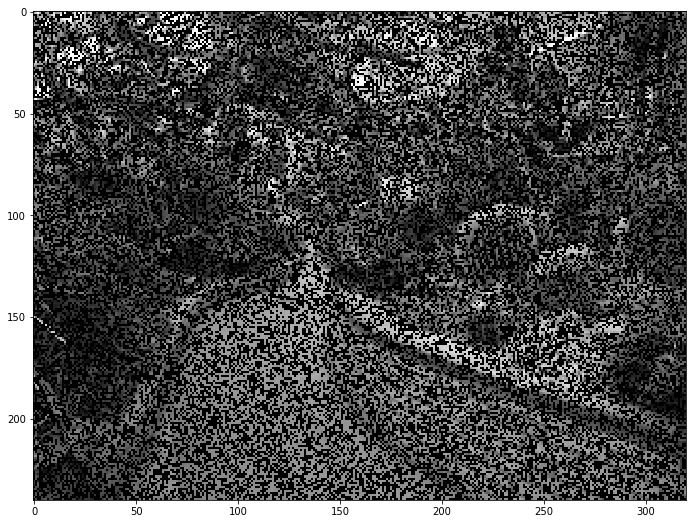

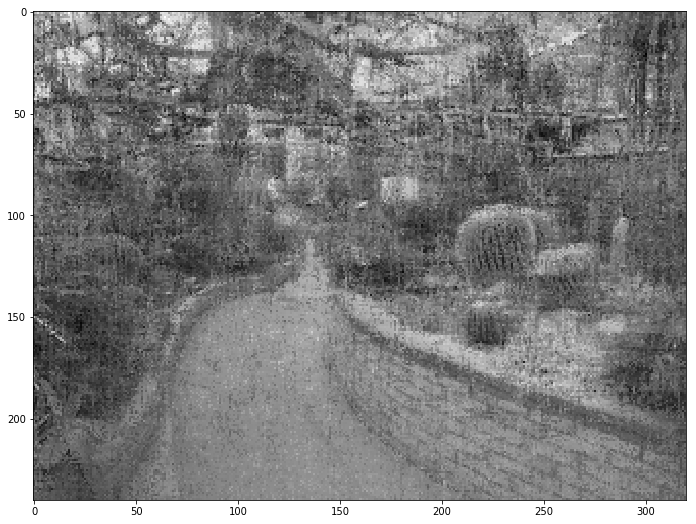

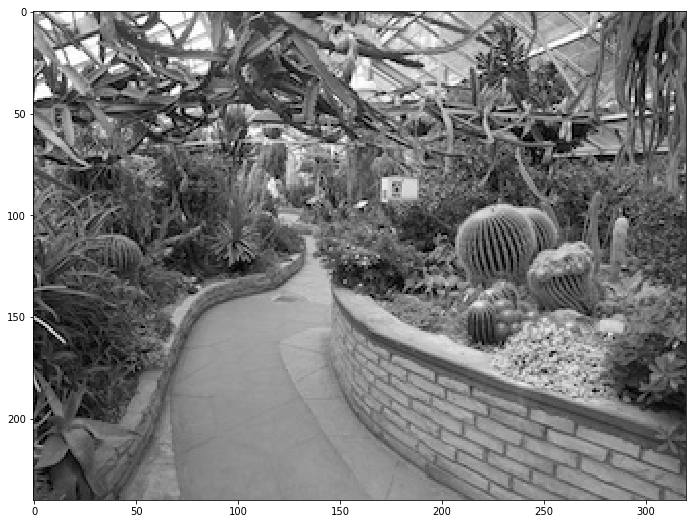

In [10]:
array2matrix.replace(np.nan, 0,inplace=True) #replace NA with zero

mask_image = array2matrix + np.multiply(anti_mask,X_imp)

plt.figure(figsize=(12,9))
plt.imshow(imgmat, cmap='gray');


plt.figure(figsize=(12, 9))
plt.imshow(mask_image, cmap='gray');

plt.figure(figsize=(12,9))
plt.imshow(imgmat_orig, cmap='gray');
